In [22]:
import pandas as pd
import numpy as np

from causallearn.search.ConstraintBased.CDNOD import cdnod
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.utils.cit import CIT
from causallearn.utils.PCUtils import SkeletonDiscovery, UCSepset, Meek
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import \
    orient_by_background_knowledge

# Feature Pruning via Logistic Regression LASSO
rpy2 was not downloading packages via the CRAN website, so please see the `src/LASSO.R` file for the implementation

In [38]:
# read in LASSO covariates
LASSO_covariates = pd.read_csv("../data/lasso_covariates.txt")
LASSO_covariates

,(Intercept),region,Acinetobacter,Agathobaculum,Alistipes,Allisonella,Bacteroides,Blautia,Burkholderia,Burkholderia.Caballeronia.Paraburkholderia,...,Prevotellaceae_NK3B31_group,Ruminococcus,Ruminococcus_gnavus_group,Schaedlerella,Senegalimassilia,Subdoligranulum,Succinivibrio,Tyzzerella,UCG.002,UCG.005
0,-0.116232,0.27305,0.0155,-0.508156,0.053707,0.229072,0.003176,0.021516,-0.027472,0.00385,...,-0.027198,-0.087087,0.061741,-0.302586,-0.033954,-0.013533,-0.008687,0.034882,-0.004466,-0.076135


In [39]:
LASSO_covariates.columns

Index(['(Intercept)', 'region', 'Acinetobacter', 'Agathobaculum', 'Alistipes',
       'Allisonella', 'Bacteroides', 'Blautia', 'Burkholderia',
       'Burkholderia.Caballeronia.Paraburkholderia', 'Clostridia_UCG.014',
       'Clostridia_vadinBB60_group', 'Corynebacterium', 'Desulfovibrio',
       'Duganella', 'Eubacterium', 'Eubacterium_eligens_group', 'Holdemanella',
       'Kineothrix', 'Knoellia', 'Lachnoclostridium', 'Mitsuokella',
       'Prevotellaceae_NK3B31_group', 'Ruminococcus',
       'Ruminococcus_gnavus_group', 'Schaedlerella', 'Senegalimassilia',
       'Subdoligranulum', 'Succinivibrio', 'Tyzzerella', 'UCG.002', 'UCG.005'],
      dtype='object')

In [40]:
# check to make sure the original set of columns does not have '.' in column names
data = pd.read_csv("../data/clean.csv")
print(data.shape)

for col in data.columns:
    if '.' in col:
        print(col)

(948, 1131)
env.OPS_17


The only column in the original data frame that has a '.' is 'env.OPS_17'. Manually add this to check.

In [41]:
# manually fix the '.' to '-' conversion done when reading table into R
LASSO_ogcolumns = []
for col in LASSO_covariates.columns:
    if '.' in col:
        if col != 'env.OPS_17':
            LASSO_ogcolumns.append(col.replace('.', '-'))
    else:
        LASSO_ogcolumns.append(col)

In [62]:
# prune data
data_short = data[['group'] + LASSO_ogcolumns[1:]]
data_short

,group,region,Acinetobacter,Agathobaculum,Alistipes,Allisonella,Bacteroides,Blautia,Burkholderia,Burkholderia-Caballeronia-Paraburkholderia,...,Prevotellaceae_NK3B31_group,Ruminococcus,Ruminococcus_gnavus_group,Schaedlerella,Senegalimassilia,Subdoligranulum,Succinivibrio,Tyzzerella,UCG-002,UCG-005
0,0,0,0.0,0.0,9.552015,0.000000,12.646568,8.553538,0.0,0.0,...,0.0,6.839446,0.000000,0.0,0.091870,2.705316,0.0,0.140222,3.503131,0.834079
1,0,0,0.0,0.0,3.172147,0.000000,22.357350,2.180851,0.0,0.0,...,0.0,3.428433,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.961799,0.041103
2,0,0,0.0,0.0,1.526039,0.000000,30.175341,0.915332,0.0,0.0,...,0.0,4.470259,0.020405,0.0,0.023321,0.421228,0.0,0.000000,0.918247,0.033523
3,0,0,0.0,0.0,1.700405,0.000000,40.884577,3.904973,0.0,0.0,...,0.0,7.956611,0.000000,0.0,0.000000,0.893744,0.0,0.516385,0.863188,0.200137
4,0,0,0.0,0.0,6.038828,0.000000,21.480262,4.359435,0.0,0.0,...,0.0,1.085492,0.152218,0.0,0.000000,1.664421,0.0,0.000000,2.450467,1.766732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,1,1,0.0,0.0,0.000000,0.000000,0.165813,1.180489,0.0,0.0,...,0.0,1.467568,0.000000,0.0,0.000000,3.224689,0.0,0.000000,0.267280,0.009899
944,1,1,0.0,0.0,0.000000,0.000000,0.000000,0.211016,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.554893,0.0,0.050800,0.000000,0.000000
945,1,1,0.0,0.0,0.000000,0.426662,0.273708,0.893576,0.0,0.0,...,0.0,0.244190,0.000000,0.0,0.000000,8.090485,0.0,0.000000,0.966028,0.037568
946,1,1,0.0,0.0,0.000000,0.000000,0.022016,0.120239,0.0,0.0,...,0.0,0.022016,0.501279,0.0,0.000000,0.104998,0.0,0.000000,0.000000,0.000000


# Causal Discovery via CD-NOD

In [63]:
# CD-NOD with 'group' as the c_indx
cg = cdnod(data_short.iloc[:, 1:].values, data_short[['group']].values) # 'group' must be the first column

  0%|          | 0/32 [00:00<?, ?it/s]

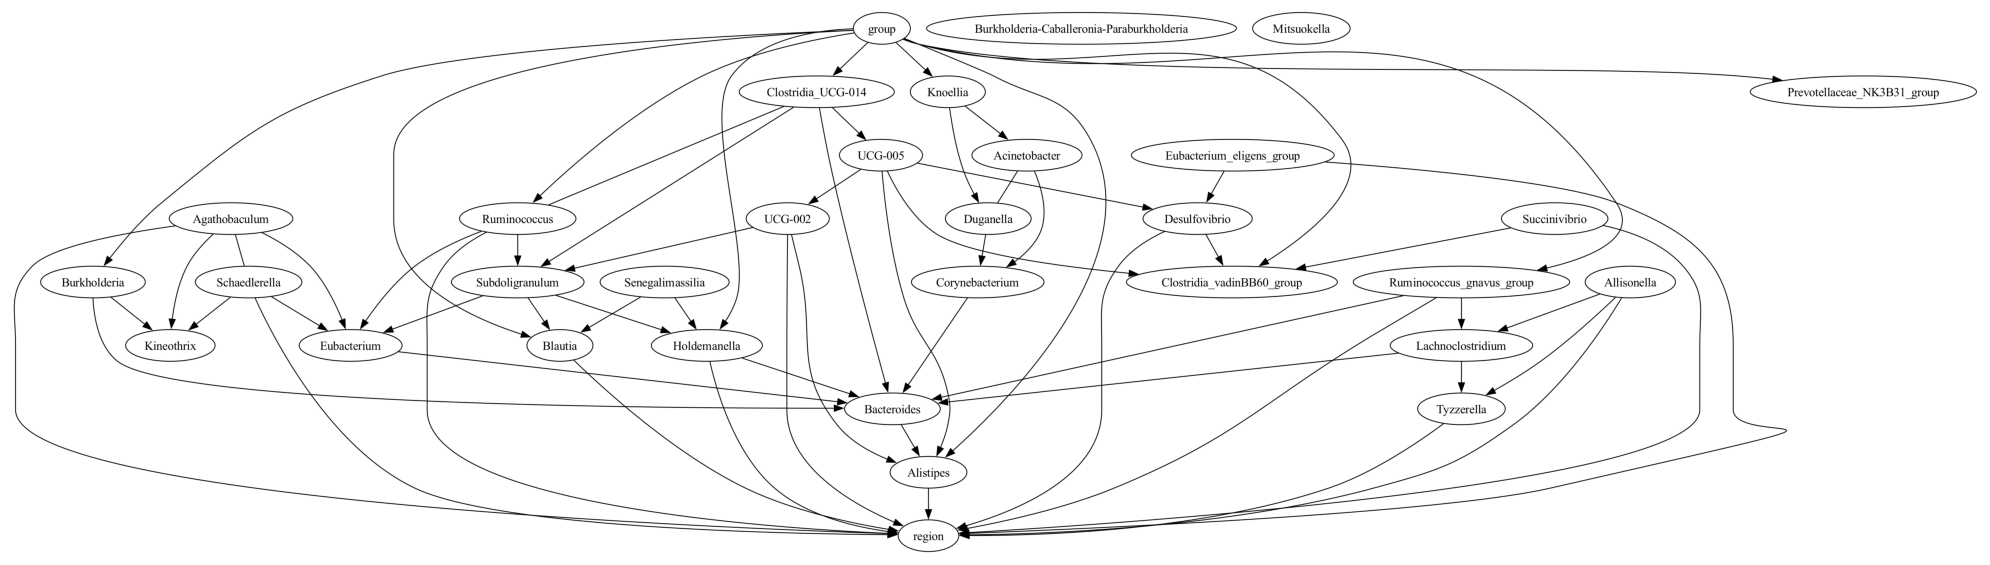

In [64]:
cg.draw_pydot_graph(labels=list(data_short.columns[1:]) + [data_short.columns[0]])

In [65]:
# we can't have edges pointing to the 'region' or 'study_site' variable
# rerun CD-NOD with some background knowledge
# essentially, tweak the CD-NOD algorithm to add the same assumption of the c_indx variable to the 'study_site' variable


# read in full clean dataframe for 'study_site' variable
data_aug = np.concatenate((data_short.iloc[:, 1:].values, data[['study_site']].values, data_short[['group']].values), axis=1)
indep_test = CIT(data_aug, 'fisherz')
cg_1 = SkeletonDiscovery.skeleton_discovery(data_aug, 0.05, indep_test, stable=True)

if 'region' in data.columns:
    nodes = cg_1.G.get_nodes()
    
    # 'region' and 'group' cannot be connected
    bk = BackgroundKnowledge() \
        .add_forbidden_by_node(nodes[0], nodes[data_aug.shape[1] - 1]) 

    # all edges from 'region' must be pointing away
    for i in cg_1.G.get_adjacent_nodes(cg_1.G.nodes[0]):
        cg_1.G.add_directed_edge(cg_1.G.nodes[0], i)

    orient_by_background_knowledge(cg_1, bk)

# # c_1 = 'group'
# c_indx_id = data_aug.shape[1] - 1
# for i in cg_1.G.get_adjacent_nodes(cg_1.G.nodes[c_indx_id]):
#     cg_1.G.add_directed_edge(cg_1.G.nodes[c_indx_id], i)

# c_2 = 'study_site'
c2_indx_id = data_aug.shape[1] - 2
for i in cg_1.G.get_adjacent_nodes(cg_1.G.nodes[c2_indx_id]):
    cg_1.G.add_directed_edge(cg_1.G.nodes[c2_indx_id], i)

cg_2 = UCSepset.uc_sepset(cg_1, 2)
cg = Meek.meek(cg_2)

  0%|          | 0/33 [00:00<?, ?it/s]

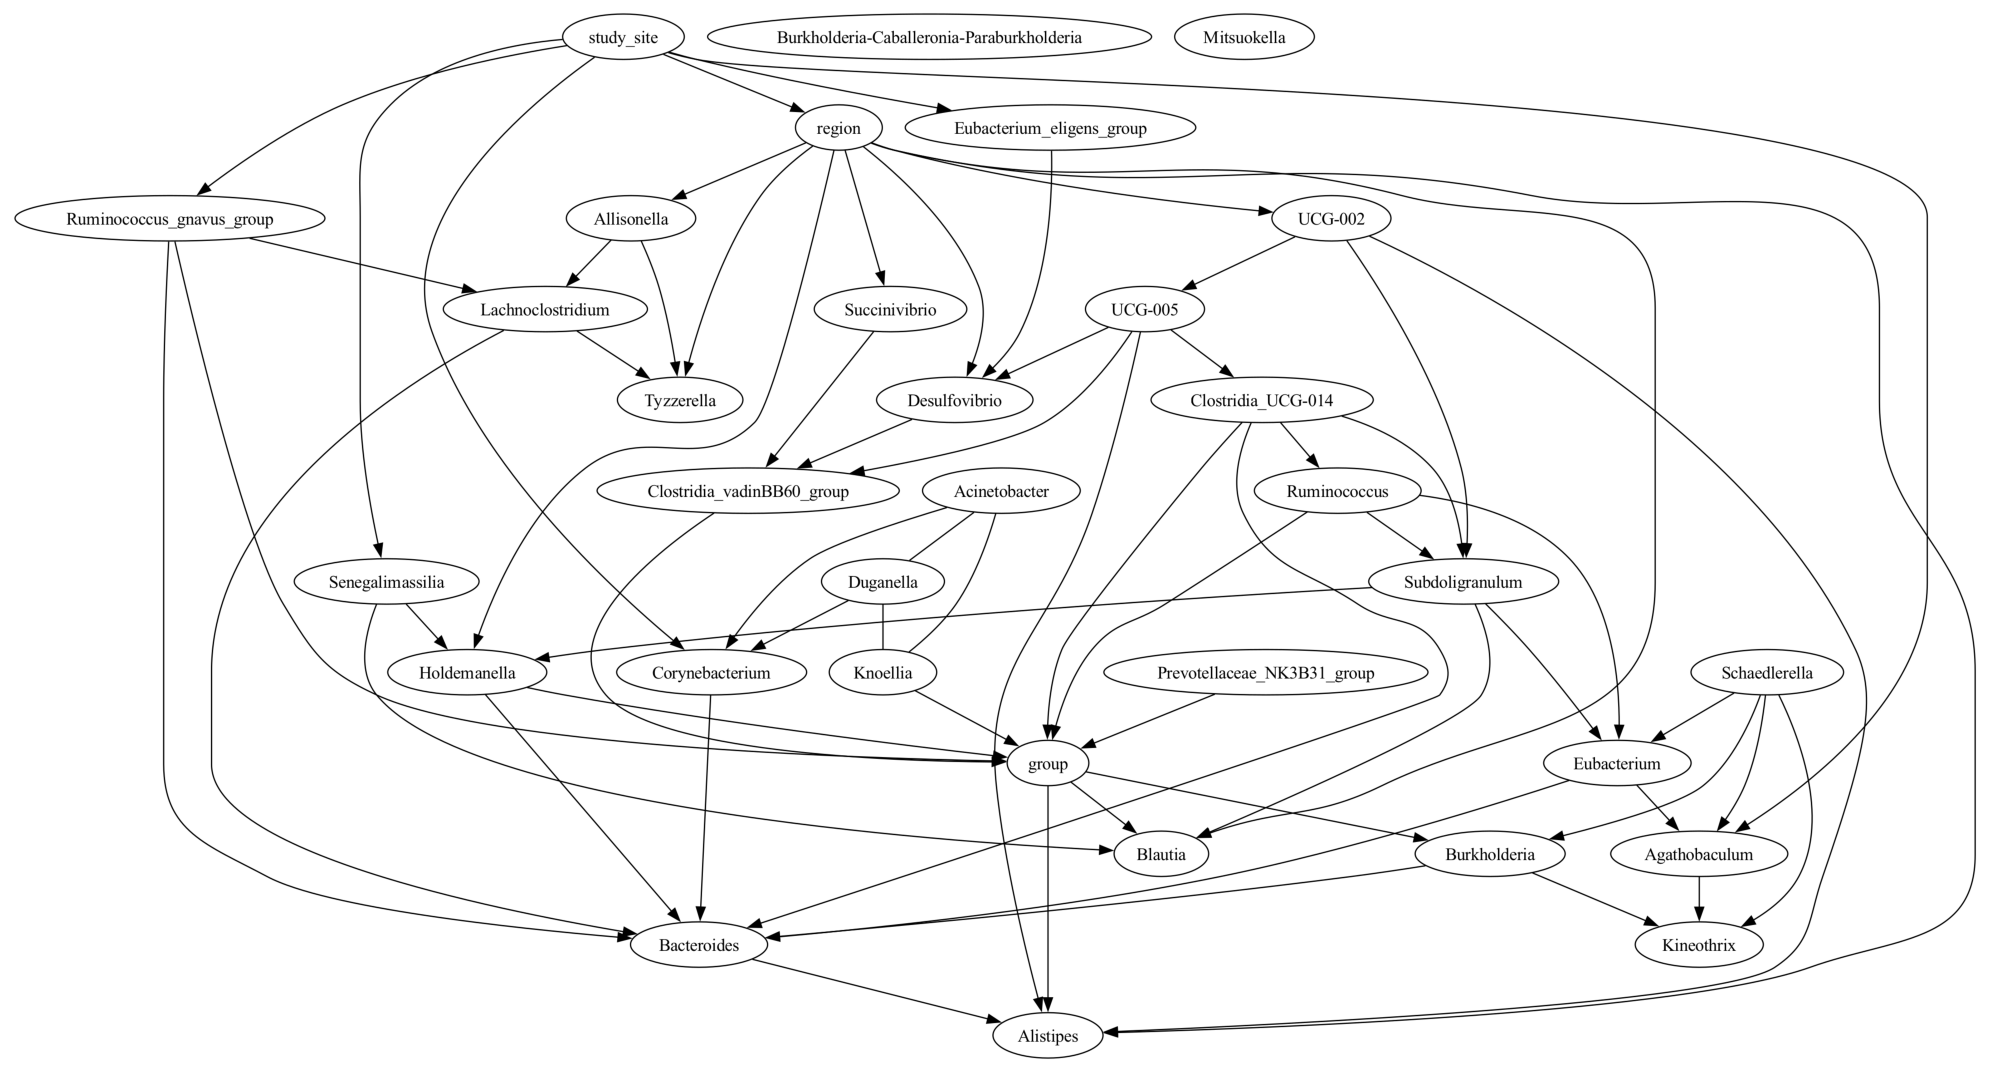

In [66]:
cg.draw_pydot_graph(labels=list(data_short.columns[1:]) + ['study_site'] + [data_short.columns[0]])

In [74]:
# print the microbes directly linked to 'group'
data_aug_col = np.array(list(data_short.columns) + ['study_site'] + [data_short.columns[0]])
adj_nodes = []
for node in cg.G.get_adjacent_nodes(cg.G.get_node(f'X{data_short.shape[1] + 1}')):
    adj_nodes.append(int(node.get_name().replace('X', '')))

print('The following microbes are directly linked to the \'group\' node:')
print('\n'.join(list(data_aug_col[adj_nodes])))

The following microbes are directly linked to the 'group' node:
Alistipes
Blautia
Burkholderia
Clostridia_UCG-014
Clostridia_vadinBB60_group
Holdemanella
Knoellia
Prevotellaceae_NK3B31_group
Ruminococcus
Ruminococcus_gnavus_group


In [72]:
# print the microbes directly linked to 'region'
adj_nodes = []
for node in cg.G.get_adjacent_nodes(cg.G.get_node(f'X1')):
    adj_nodes.append(int(node.get_name().replace('X', '')))

print('The following microbes are directly linked to the \'region\' node:')
print('\n'.join(list(data_aug_col[adj_nodes])))

The following microbes are directly linked to the 'region' node:
Alistipes
Allisonella
Blautia
Desulfovibrio
Holdemanella
Succinivibrio
Tyzzerella
UCG-002
study_site


In [75]:
# print the microbes directly linked to 'study_site'
adj_nodes = []
for node in cg.G.get_adjacent_nodes(cg.G.get_node(f'X{data_short.shape[1]}')):
    adj_nodes.append(int(node.get_name().replace('X', '')))

print('The following microbes are directly linked to the \'study_site\' node:')
print('\n'.join(list(data_aug_col[adj_nodes])))

The following microbes are directly linked to the 'study_site' node:
region
Agathobaculum
Corynebacterium
Eubacterium_eligens_group
Ruminococcus_gnavus_group
Senegalimassilia
